In [ ]:
# Load libraries
library(ggplot2)
library(glmnet)
library(pls)
library(forecast)
library(tseries)

### (a)

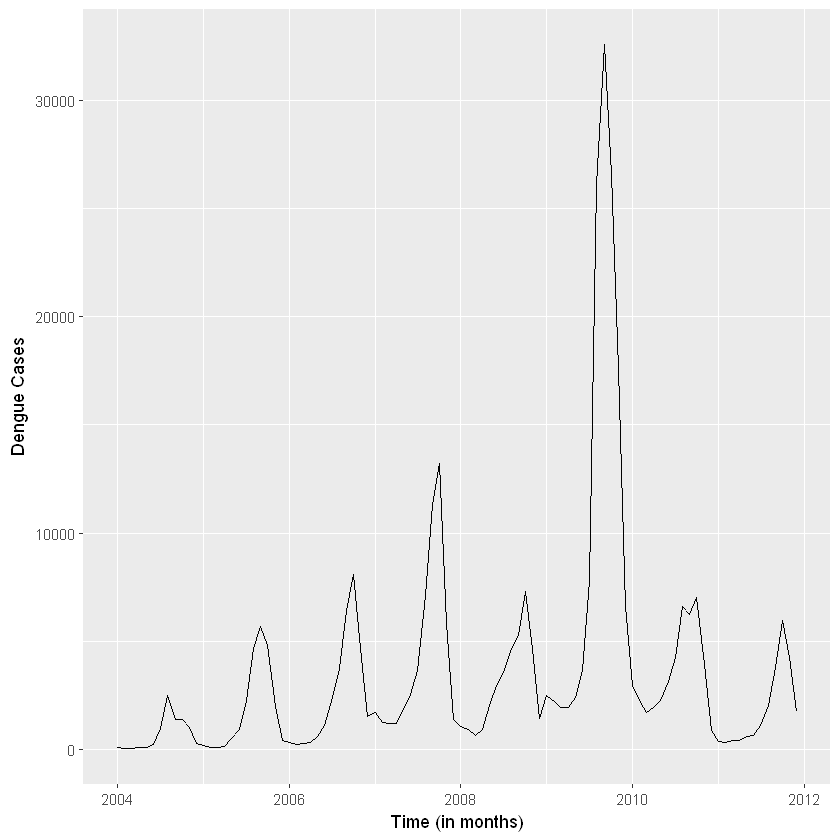

In [3]:
# Load and transform data
dengue <- read.csv('C:/Users/.../Dengue_trends_AM_111.csv')
dengue <- dengue[1:96,]
colnames(dengue) <- c('date','cases','searches')
dengue$date <- as.Date(dengue$date, format="%m/%d/%Y")

# Plot dengue cases as as function of time
qplot(date, cases, data=dengue, geom=c('line')) + 
  labs(x="Time (in months)", y="Dengue Cases")

### (b)
For the training period 2004-2006, the best line that explains the number of cases of Dengue as a function of the number of searches of the term "dengue" is $y=2155.3+2926.4x$.

In [8]:
# Subset data 
dengue_train <- dengue[dengue$date < as.Date("2007-01-01"),]
dengue_pred <- dengue[dengue$date >= as.Date("2007-01-01"),]

# Train least squares model
fit_ls <- glm(cases~searches, data=dengue_train)
b0 <- fit_ls$coefficients[1]
b1 <- fit_ls$coefficients[2]

### (c)
The plot of the number of Dengue cases as a function of searches of the term "dengue" shows that the number of Dengue cases each month is usually $<10,000$ but that there are a few months with a much high number of dengue cases. There results are consistent with the results of the plot from (a).


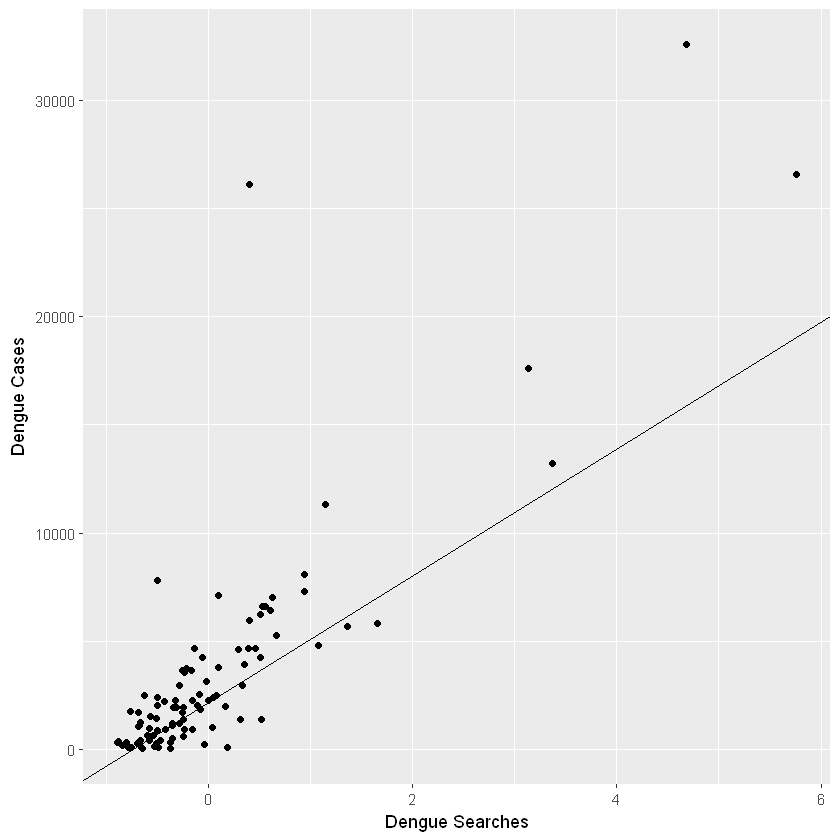

In [9]:
# Plot dengue cases as a function of dengue searches
qplot(searches, cases, data=dengue, geom=c('point')) + geom_abline(intercept=b0, slope=b1) + labs(x="Dengue Searches", y="Dengue Cases")

### (d)
For the prediction period 2007-2011, the predicted number of dengue cases (in red) tends to underestimate the observed number of cases.


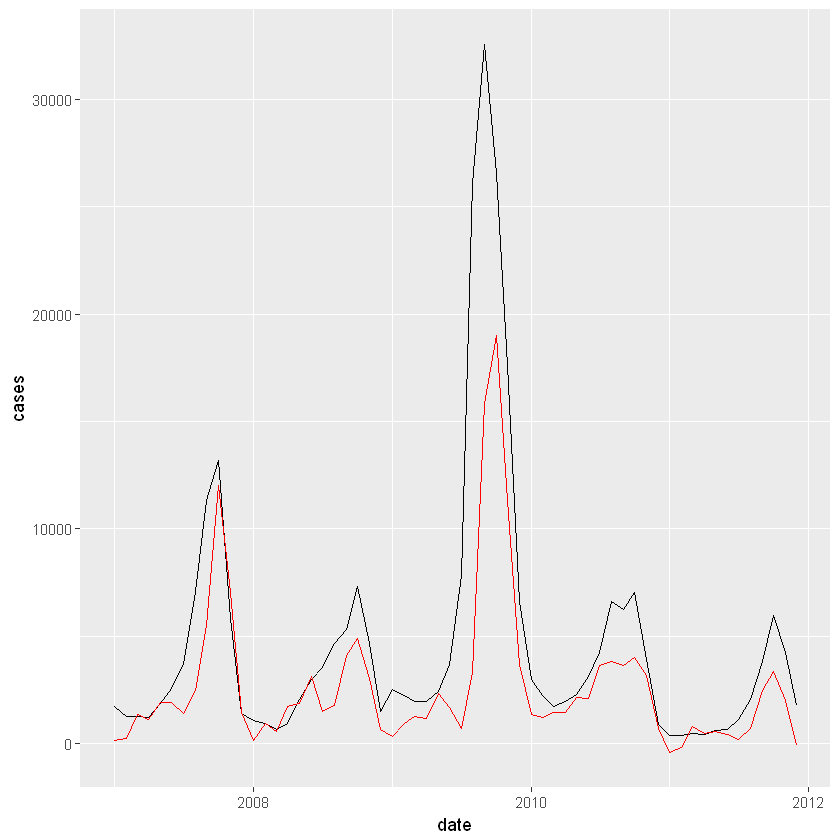

In [10]:
# Test least squares model from (b)
dengue_pred$pred <- predict(fit_ls, dengue_pred)

# Dengue cases vs. searches
qplot(date, cases, data=dengue_pred, geom=c('line')) + geom_line(data=dengue_pred, aes(date, pred), colour='red')

### (e) 
First, I tried to improve the model by transforming the number of searches. The transformations I considered were the logarithm, square root, and inverse. All of the transformations produced models that performed worse than the original OLS model.

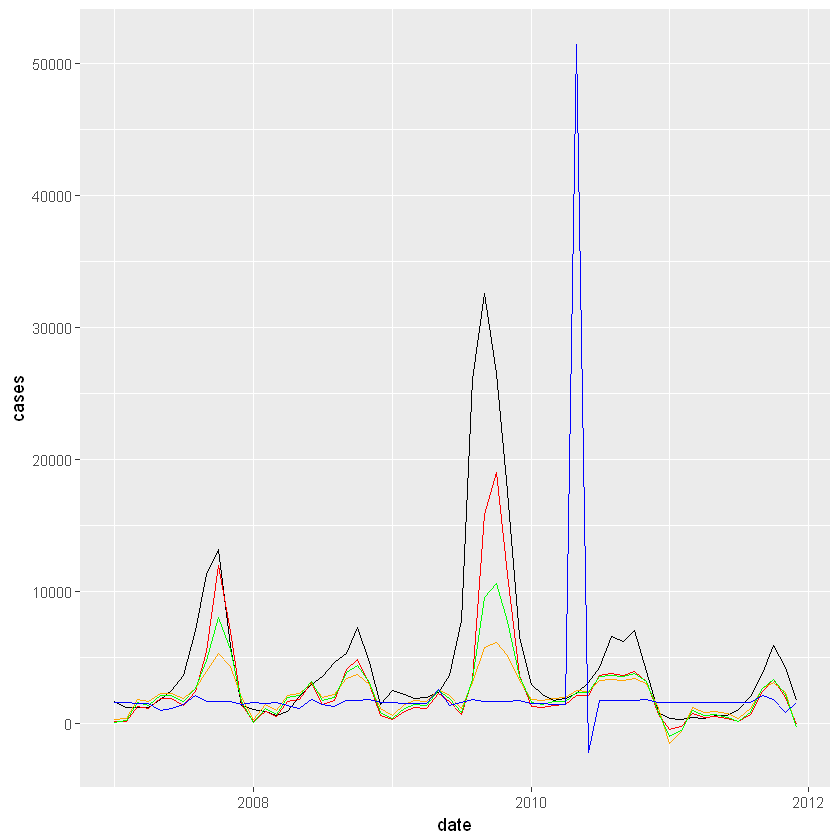

In [11]:
# Tranformations
dengue_train$log_searches <- log(dengue_train$searches+1)
dengue_train$sqrt_searches <- sqrt(dengue_train$searches+1)
dengue_train$inv_searches <- (dengue_train$searches)^(-1)

dengue_pred$log_searches <- log(dengue_pred$searches+1)
dengue_pred$sqrt_searches <- sqrt(dengue_pred$searches+1)
dengue_pred$inv_searches <- (dengue_pred$searches)^(-1)

# Train least squares models with transformed searches
fit_ls_log <- glm(cases~log_searches, data=dengue_train)
fit_ls_sqrt <- glm(cases~sqrt_searches, data=dengue_train)
fit_ls_inv <- glm(cases~inv_searches, data=dengue_train)

# Get intercepts
b0_log <- fit_ls_log$coefficients[1]
b0_sqrt <- fit_ls_sqrt$coefficients[1]
b0_inv <- fit_ls_inv$coefficients[1]

# Get slopes
b1_log <- fit_ls_log$coefficients[2]
b1_sqrt <- fit_ls_sqrt$coefficients[2]
b1_inv <- fit_ls_inv$coefficients[2]

# Test least squares models with transformed searches
dengue_pred$pred_log <- predict(fit_ls_log, dengue_pred)
dengue_pred$pred_sqrt <- predict(fit_ls_sqrt, dengue_pred)
dengue_pred$pred_inv <- predict(fit_ls_inv, dengue_pred)

# Dengue cases vs. transformed searches
qplot(date, cases, data=dengue_pred, geom=c('line')) +
  geom_line(data=dengue_pred, aes(date, pred), colour='red') +
  geom_line(data=dengue_pred, aes(date, pred_log), colour='orange') +
  geom_line(data=dengue_pred, aes(date, pred_sqrt), colour='green') +
  geom_line(data=dengue_pred, aes(date, pred_inv), colour='blue')

The OLS model that includes the quadratic effect of the number of searches also performed worse than the original OLS model.

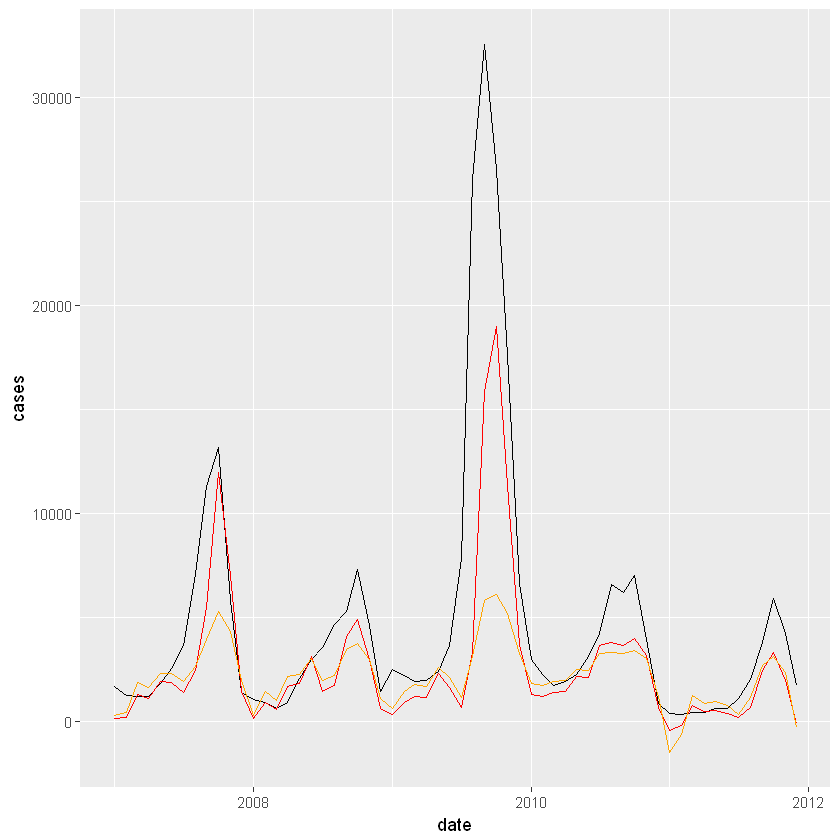

In [12]:
# Train quadratic model
fit_ls_quad <- glm(cases~searches+searches^2, data=dengue_train)
b0_quad <- fit_ls_quad$coefficients[1]
b1_quad <- fit_ls_quad$coefficients[2]

# Test quadratic model
dengue_pred$pred_quad <- predict(fit_ls_quad, dengue_pred)

# Dengue cases vs. searches
qplot(date, cases, data=dengue_pred, geom=c('line')) +
  geom_line(data=dengue_pred, aes(date, pred), colour='red') +
  geom_line(data=dengue_pred, aes(date, pred_log), colour='orange')

The ridge regression, lasso, PLS, and local regression methods did not produce better models than the original OLS model either. The problem is that all of the models I have attempted until now fail to take into account the cyclical nature of the data.

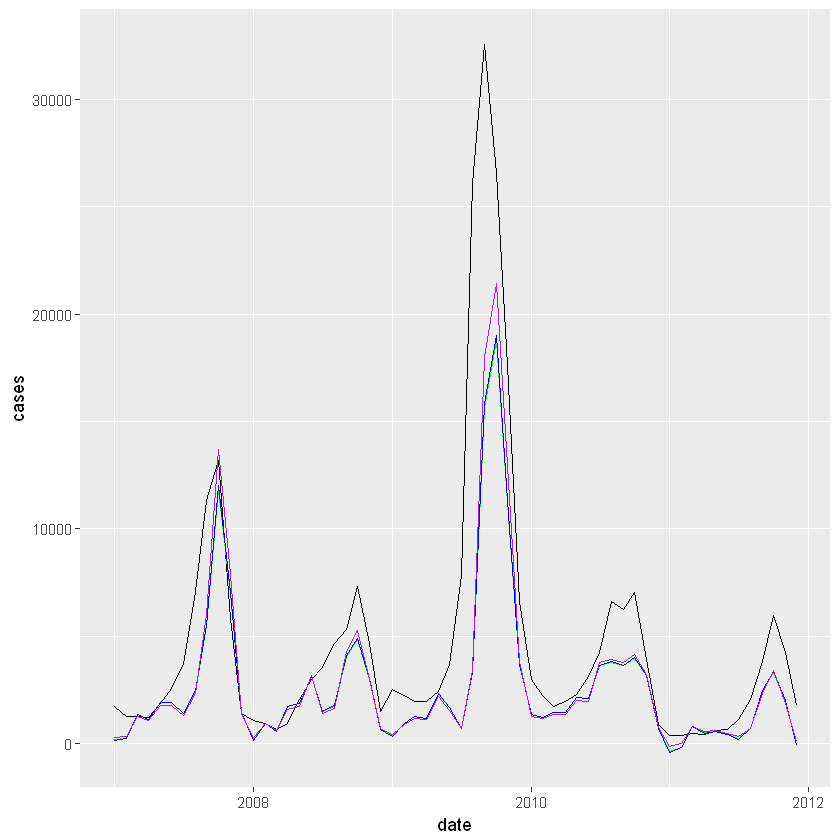

In [14]:
# Initialize variables
matrix_train = model.matrix(cases~searches, data=dengue_train) 
matrix_pred = model.matrix(cases~searches, data=dengue_pred) 
grid = 10 ^ seq(4, -2, length = 100) 

# Train models
fit_ridge = glmnet(matrix_train, dengue_train$cases, alpha=0, lambda=grid, thresh=1e-12)
fit_lasso = glmnet(matrix_train, dengue_train$cases, alpha=1, lambda=grid, thresh=1e-12)
fit_pls = plsr(cases~searches, data=dengue_train, scale=TRUE, validation="CV")
fit_loess = loess(cases~searches,degree=1,data=dengue_train,span=1, control=loess.control(surface="direct")) 

# Choose parameters using cross-validation
cv_ridge = cv.glmnet(matrix_train, dengue_train$cases, alpha=0, lambda=grid, thresh=1e-12) 
cv_lasso = cv.glmnet(matrix_train, dengue_train$cases, alpha=1, lambda=grid, thresh=1e-12) 
lambda_ridge = cv_ridge$lambda.min 
lambda = cv_lasso$lambda.min 

# Test models
pred_ridge = predict(fit_ridge, s=lambda, newx=matrix_pred) 
pred_lasso = predict(fit_lasso, s=lambda, newx=matrix_pred) 
pred_pls = predict(fit_pls, dengue_pred, ncomp=1)
fit_local = loess(cases~searches,degree=1,data=dengue_train,span=1, control=loess.control(surface="direct")) 

dengue_pred$pred_ridge <- pred_ridge
dengue_pred$pred_lasso <- pred_lasso
dengue_pred$pred_pls <- pred_pls
pred_local = predict(fit_local, dengue_pred)

# Dengue cases vs. searches
qplot(date, cases, data=dengue_pred, geom=c('line')) +
  geom_line(data=dengue_pred, aes(date, pred), colour="red") +
  geom_line(data=dengue_pred, aes(date, pred_ridge), colour='orange') +
  geom_line(data=dengue_pred, aes(date, pred_lasso), colour='green') +
  geom_line(data=dengue_pred, aes(date, pred_pls), colour='blue') +
  geom_line(data=dengue_pred, aes(date, pred_local), colour='purple')
